In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)
import scipy 

from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

from ipynb.fs.full.CFPCA import CFPCA

from scipy.ndimage import gaussian_filter1d
from scipy.integrate import simps


In [2]:
co2 = pd.read_csv('co2_data.csv')
gdp = pd.read_csv("all_gdps.csv")
# Assuming 'co2' is your DataFrame

# Define keywords that indicate a non-country entity
non_country_keywords = ['Africa', 'Asia', 'Europe', 'GCP', 'International', 'Union', 'countries', 'Oceania', 'America', 'World']

# Filter out non-country entities
filtered_co2 = co2[~co2['Entity'].str.contains('|'.join(non_country_keywords))]

In [3]:
gdp_columns = gdp.columns[3:]  # Adjust this based on the actual structure of your CSV
gdp[gdp_columns] = gdp[gdp_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

gdp['Average GDP 2000-2022'] = gdp[gdp_columns].mean(axis=1)

# Rename the 'Country Code' column in the GDP dataset to 'Code' for merging
gdp.rename(columns={'Country Code': 'Code'}, inplace=True)

# Merge the filtered CO2 data with the modified GDP data on 'Code'
merged_data = pd.merge(filtered_co2, gdp[['Code', 'Average GDP 2000-2022']], on='Code', how='left')

# Select only the required columns for the final dataset
final_dataset = merged_data[['Entity', 'Code', 'Year', 'Annual CO₂ emissions', 'Average GDP 2000-2022']]
final_dataset.head()

,Entity,Code,Year,Annual CO₂ emissions,Average GDP 2000-2022
0,Afghanistan,AFG,1949,14656.0,192.657425
1,Afghanistan,AFG,1950,84272.0,192.657425
2,Afghanistan,AFG,1951,91600.0,192.657425
3,Afghanistan,AFG,1952,91600.0,192.657425
4,Afghanistan,AFG,1953,106256.0,192.657425


In [4]:
new_column_names = ['Entity', 'Code', 'Year', 'Co2', 'Avg_GDP']

# Assign the new column names to the filtered_co2 DataFrame
final_dataset.columns = new_column_names
final_dataset = final_dataset[(final_dataset['Year'] >= 2000) & (final_dataset['Year'] < 2023)]
final_dataset.head()

,Entity,Code,Year,Co2,Avg_GDP
51,Afghanistan,AFG,2000,1047127.94,192.657425
52,Afghanistan,AFG,2001,1069098.00,192.657425
53,Afghanistan,AFG,2002,1340995.00,192.657425
54,Afghanistan,AFG,2003,1559602.00,192.657425
55,Afghanistan,AFG,2004,1237247.00,192.657425


In [5]:
Europe = [
    'Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus',
    'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
    'Czechia', 'Denmark','Estonia', 'Finland', 'France', 'Georgia', 'Germany', 
      'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova',
    'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland',
    'Portugal', 'Romania', 'Russia',
      'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom'
  ]
Asia = [
    'Bahrain', 'Bangladesh', 'Bhutan', 'Cambodia',
    'China', 'Hong Kong', 'India', 'Indonesia', 'Iran', 'Iraq', 
      'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyzstan', 'Laos',
          'Macao', 'Malaysia', 'Maldives', 'Mongolia', 'Myanmar', 'Nepal',
     'Oman', 'Philippines', 'Qatar',
      'Saudi Arabia', 'Singapore', 'South Korea', 'Tajikistan', 'Thailand', 
      'Turkey', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Vietnam', 'Yemen'
  ]

Caribbean = [
    'Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Cuba', 'Dominica',
    'Dominican Republic', 'Grenada', 'Haiti', 'Jamaica', 'Saint Kitts and Nevis',
    'Saint Lucia', 'Saint Vincent and the Grenadines', 'Trinidad and Tobago'
]

Neither =  [
    'Afghanistan','Algeria', 'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda',
    'Argentina', 'Aruba', 'Australia', 'Bahamas', 'Barbados', 'Belize',
    'Benin', 'Bermuda', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
    'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei', 'Burkina Faso', 'Burundi',
    'Cameroon', 'Canada', 'Cape Verde', 'Chad', 'Chile', 'Christmas Island',
    'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica',
    "Cote d'Ivoire", 'Cuba', 'Curacao', 'Democratic Republic of Congo'
  'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 
      'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji', 
      'French Polynesia', 'Gabon', 'Gambia', 'Ghana', 'Grenada', 'Guatemala', 'Guinea', 
      'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Jamaica', 'Kenya', 'Kiribati',
  'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali',
    'Marshall Islands', 'Mauritania', 'Mauritius', 'Mexico', 'Micronesia (country)',
    'Montserrat', 'Morocco', 'Mozambique', 'Namibia', 'Nauru', 'New Caledonia',
    'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Niue', 'Palau', 'Panama',
    'Papua New Guinea', 'Paraguay', 'Peru', 'Rwanda', 'Saint Helena',
    'Saint Kitts and Nevis', 'Saint Lucia',
  'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'Samoa', 'Sao Tome and Principe', 'Senegal', 
      'Seychelles', 'Sierra Leone', 'Sint Maarten (Dutch part)', 'Solomon Islands', 'Somalia', 'South Sudan', 
      'Sudan', 'Suriname', 'Tanzania', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turks and Caicos Islands', 
      'Tuvalu', 'Uganda', 'United States', 'Uruguay', 'Vanuatu', 'Venezuela', 'Wallis and Futuna', 
    'Zambia', 'Zimbabwe','East Timor', 'Lebanon','North Korea', 'Pakistan', 'Palestine', 'Sri Lanka', 'Syria', 'Greenland',
'Liechtenstein', 'Kosovo', 'Taiwan']




In [6]:
def assign_continent(country):
    if country in Europe:
        return 'Europe'
    elif country in Asia:
        return 'Asia'
    else:
        return 'Other'

# Create an explicit copy of the slice to avoid SettingWithCopyWarning
final_dataset = final_dataset.copy()

# Now apply the function to assign continents without encountering the warning
final_dataset['Continent'] = final_dataset['Entity'].apply(assign_continent)


In [7]:
final_dataset.head()

,Entity,Code,Year,Co2,Avg_GDP,Continent
51,Afghanistan,AFG,2000,1047127.94,192.657425,Other
52,Afghanistan,AFG,2001,1069098.00,192.657425,Other
53,Afghanistan,AFG,2002,1340995.00,192.657425,Other
54,Afghanistan,AFG,2003,1559602.00,192.657425,Other
55,Afghanistan,AFG,2004,1237247.00,192.657425,Other


C:\Users\Eric\AppData\Local\Temp\ipykernel_20368\2876967578.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Log_Co2'] = np.log(data['Co2'] + 1)


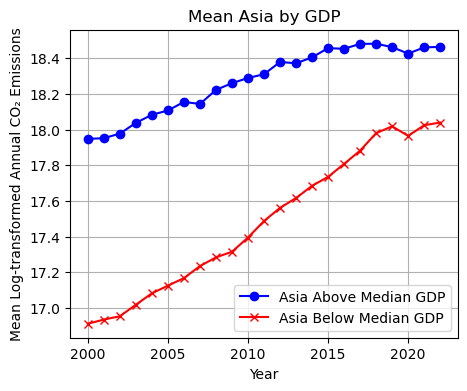

C:\Users\Eric\AppData\Local\Temp\ipykernel_20368\2876967578.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Log_Co2'] = np.log(data['Co2'] + 1)


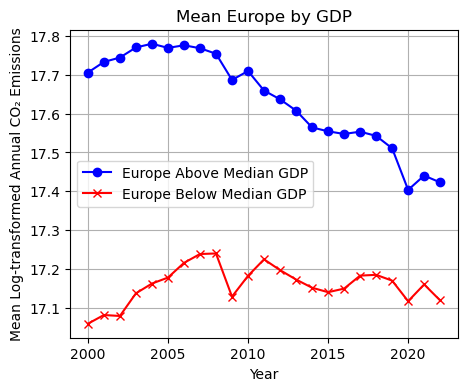

In [8]:
def plot_mean_log_co2_by_gdp_status(data, continent_name, median_gdp):
    # Apply log transformation to Co2 emissions + 1 to handle any zeros
    data['Log_Co2'] = np.log(data['Co2'] + 1)
    
    # Split the data based on the median GDP
    above_median = data[data['Avg_GDP'] > median_gdp]
    below_median = data[data['Avg_GDP'] <= median_gdp]
    
    # Calculate the mean of the log-transformed CO2 emissions per year for above and below median GDP
    mean_log_co2_above = above_median.groupby('Year')['Log_Co2'].mean()
    mean_log_co2_below = below_median.groupby('Year')['Log_Co2'].mean()
    
    plt.figure(figsize=(5, 4))
    plt.plot(mean_log_co2_above.index, mean_log_co2_above.values, label=f'{continent_name} Above Median GDP', color='blue', marker='o')
    plt.plot(mean_log_co2_below.index, mean_log_co2_below.values, label=f'{continent_name} Below Median GDP', color='red', marker='x')
    
    plt.title(f'Mean {continent_name} by GDP')
    plt.xlabel('Year')
    plt.ylabel('Mean Log-transformed Annual CO₂ Emissions')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate the median of unique 'Avg_GDP' values for Asia and Europe
unique_asia_gdp_median = final_dataset[final_dataset['Continent'] == 'Asia'].drop_duplicates('Entity')['Avg_GDP'].median()
unique_europe_gdp_median = final_dataset[final_dataset['Continent'] == 'Europe'].drop_duplicates('Entity')['Avg_GDP'].median()

# Plot for Asia and Europe, applying log transformation before calculating means
plot_mean_log_co2_by_gdp_status(final_dataset[final_dataset['Continent'] == 'Asia'], "Asia", unique_asia_gdp_median)
plot_mean_log_co2_by_gdp_status(final_dataset[final_dataset['Continent'] == 'Europe'], "Europe", unique_europe_gdp_median)


In [9]:
# Step 1: Calculate the most common time series length for each continent
# This involves grouping by continent and entity, counting the number of years for each, and then finding the mode (most common length) for Asia and Europe
continent_lengths_mode = final_dataset.groupby(['Continent', 'Entity']).size().groupby(level=0).agg(lambda x: x.mode()[0])

# Step 2: Identify countries with time series lengths different from the mode for their continent
# We first calculate the size of each country's time series again to compare against the mode
country_series_lengths = final_dataset.groupby(['Continent', 'Entity']).size()

# Then, we identify countries not matching the mode length for their continent
mismatched_countries = country_series_lengths[country_series_lengths != country_series_lengths.index.get_level_values('Continent').map(continent_lengths_mode)].index.get_level_values('Entity').unique()

# Step 3: Remove data for these countries from the DataFrame
final_dataset = final_dataset[~final_dataset['Entity'].isin(mismatched_countries)]

# Verification (Optional): List the removed countries to ensure correctness
print("Countries removed due to different time series lengths:", mismatched_countries.tolist())



Countries removed due to different time series lengths: ['Antarctica', 'Kosovo']


In [10]:
# Filter for European countries
europe_co2 = final_dataset[final_dataset['Continent'] == 'Europe']

# Group by 'Entity' and extract CO2 emissions into a list for each country
europe_list = [group['Co2'].tolist() for _, group in europe_co2.groupby('Entity')]

asia_co2 = final_dataset[final_dataset['Continent'] == 'Asia']

# Group by 'Entity' and extract CO2 emissions into a list for each country
asia_list = [group['Co2'].tolist() for _, group in asia_co2.groupby('Entity')]

# asia_co2_series now contains the list of lists for Asian countries' CO2 emissions


In [11]:
# Assuming europe_list is your list of lists
lengths = [len(series) for series in asia_list]

# Check if all series have the same length
if len(set(lengths)) == 1:
    print("All series have the same length.")
else:
    print("Series have different lengths.")

# Optionally, print the lengths to see the variation
print("Lengths of series:", lengths)


All series have the same length.
Lengths of series: [23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]


In [12]:
def standardize_time_series(data_list, log_transform, across_time_points):
    # Apply log transformation if requested
    if log_transform:
        data_list = [np.log1p(series) for series in data_list]

    if across_time_points:
        # Convert to NumPy array for easier manipulation
        data_array = np.array(data_list)
        # Standardize across all time points
        means = np.mean(data_array, axis=0)
        stds = np.std(data_array, axis=0)
        standardized_data = (data_array - means) / stds
        standardized_data = standardized_data.tolist()

        return standardized_data
    
    return data_list


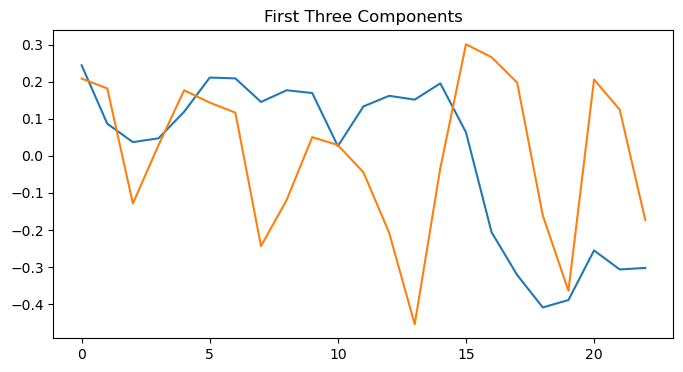

In [13]:
def compute_and_plot_components(foreground, background, alpha):
    # Define time points
    t = np.linspace(0, 22, 23)
    fd_X = skfda.FDataGrid(foreground, t)
    fd_Y = skfda.FDataGrid(background, t)
    basis = skfda.representation.basis.BSplineBasis(n_basis=9)
    X_basis = fd_X.to_basis(basis)
    Y_basis = fd_Y.to_basis(basis)

    X_fd_data = fd_X.data_matrix.reshape(fd_X.data_matrix.shape[:-1])
    Y_fd_data = fd_Y.data_matrix.reshape(fd_Y.data_matrix.shape[:-1])

    X_identity = np.eye(len(fd_X.grid_points[0]))
    Y_identity = np.eye(len(fd_Y.grid_points[0]))

    X_weights = scipy.integrate.simpson(X_identity, fd_X.grid_points[0])
    Y_weights = scipy.integrate.simpson(Y_identity, fd_Y.grid_points[0])

    X_weights_matrix = np.diag(X_weights)
    Y_weights_matrix = np.diag(Y_weights)

    X_factorization_matrix = X_weights_matrix.astype(float)
    Y_factorization_matrix = Y_weights_matrix.astype(float)

    X_Lt = np.linalg.cholesky(X_factorization_matrix).T
    Y_Lt = np.linalg.cholesky(Y_factorization_matrix).T

    new_data_matrix_X = X_fd_data @ X_weights_matrix
    new_data_matrix_X = np.linalg.solve(X_Lt.T, new_data_matrix_X.T).T

    new_data_matrix_Y = Y_fd_data @ Y_weights_matrix
    new_data_matrix_Y = np.linalg.solve(Y_Lt.T, new_data_matrix_Y.T).T

    # Center the matrix X by subtracting the mean of each column
    X_centered = new_data_matrix_X #- np.mean(new_data_matrix_X, axis=0)
    Y_centered = new_data_matrix_Y #- np.mean(new_data_matrix_Y, axis=0)

    Vx = (1 / (len(foreground) - 1)) * np.dot(X_centered.T, X_centered)
    Vy = (1 / (len(background) - 1)) * np.dot(Y_centered.T, Y_centered)

    # Perform the eigen decomposition on the covariance matrix V
    eigenvalues, eigenvectors = np.linalg.eig(Vx - alpha * Vy)

    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    components = np.linalg.solve(X_Lt, sorted_eigenvectors[:, :4]).T

    # Plot the first three components
    plt.figure(figsize=(8, 4))
    for i in range(2):
        plt.plot(components[i], label=f'Component {i+1}')
    #plt.legend()
    plt.title('First Three Components')
    plt.show()

    return components

standardized_asia_list = standardize_time_series(asia_list, log_transform=True, across_time_points = True)
standardized_europe_list = standardize_time_series(europe_list, log_transform=True, across_time_points=True)


#shared_components = compute_and_plot_components(standardized_europe_list,standardized_asia_list , 0)
unique_components = compute_and_plot_components(standardized_asia_list,standardized_europe_list,3)

#NON PERIODIC CASE

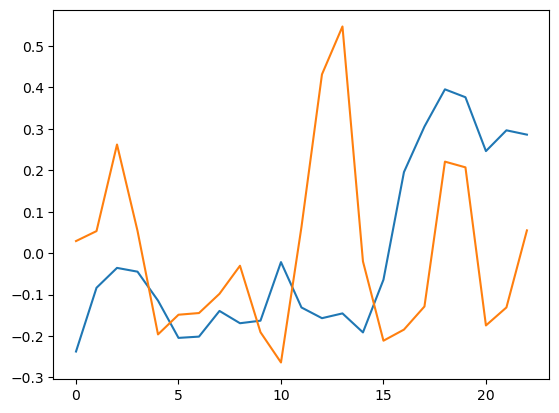

In [14]:
t = np.linspace(0, 22, 23)
components = CFPCA(standardized_asia_list, standardized_europe_list, 3, t, True)

plt.plot(t, components[:,0])
plt.plot(t, components[:,1])

Text(0.5, 1.0, 'FPCA')

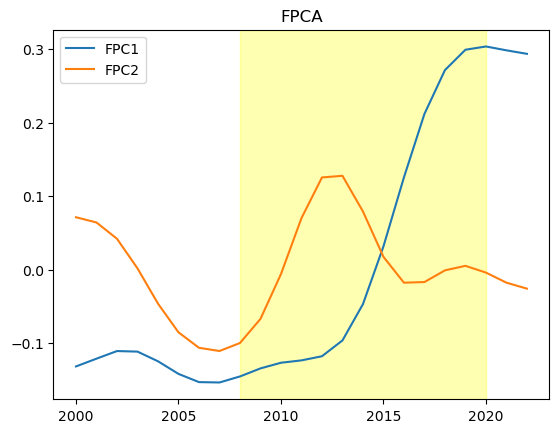

In [19]:
def smooth_time_series_with_ema_and_gaussian(components, window_size, alpha=0.3):
    smoothed_components = {'sma': [], 'ema': [], 'gaussian': []}
    for series in components:
        if not isinstance(series, pd.Series):
            series = pd.Series(series)
        
        # Simple Moving Average with larger window
        smoothed_sma = series.rolling(window=window_size, center=True).mean()
        
        # Exponential Moving Average
        smoothed_ema = series.ewm(alpha=alpha, adjust=False).mean()
        
        # Gaussian filter
        smoothed_gaussian = pd.Series(gaussian_filter1d(series, sigma=window_size/2))
        
        smoothed_components['sma'].append(smoothed_sma)
        smoothed_components['ema'].append(smoothed_ema)
        smoothed_components['gaussian'].append(smoothed_gaussian)
    
    return smoothed_components


first_two = [components[:,0], components[:,1]]  # Assuming components is already defined
smoothed_components = smooth_time_series_with_ema_and_gaussian(first_two, window_size=4, alpha=0.3)
plt.plot(list(range(2000,2023)),smoothed_components['gaussian'][0])
plt.plot(list(range(2000,2023)),smoothed_components['gaussian'][1])
plt.axvspan(2008, 2020, color='yellow', alpha=0.3)

plt.legend(['FPC1', 'FPC2'])
plt.title("FPCA")
#plt.plot(tech_plot['Date'],smoothed_components['gaussian'][2])

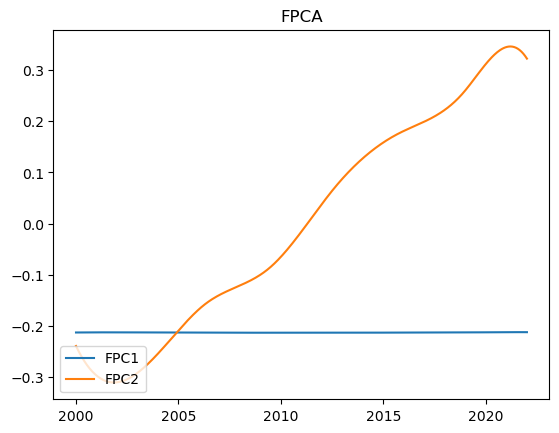

array([0.99525152, 0.00392795])

In [16]:
gb_fd = skfda.FDataGrid(standardized_europe_list,list(range(2000,2023)))

# Convert to Fourier basis representation
basis = BSplineBasis(n_basis=10)
basis_fd = gb_fd.to_basis(basis)

# Perform FPCA on the residuals in basis representation
fpca = FPCA(n_components=2, components_basis=basis)
fpca.fit(basis_fd)

# Plot FPCA components
fpca.components_.plot()
plt.title("FPCA")
plt.legend(["FPC1", "FPC2"], loc="lower left")
plt.show()
fpca.explained_variance_ratio_ 

In [52]:
def calculate_pc_scores_from_lists(data_lists, eigenvector):
    """
    Calculate the PC scores for each time series represented by a list in data_lists.
    
    Parameters:
    - data_lists: List of lists, each inner list is a time series for a company.
    - eigenvector: The eigenvector to use for calculating PC scores.
    - t: The time array over which to integrate.
    
    Returns:
    - A numpy array with PC scores for each time series.
    """
    # Convert data lists to a numpy array for efficient computation
    data_array = np.array(data_lists)
    
    # Calculate the integral using the trapezoidal rule for each time series
    pc_scores = np.array([simps(data_array[i] * np.real(eigenvector), dx = 1) for i in range(data_array.shape[0])])
    return pc_scores


unique_pc_score1 = calculate_pc_scores_from_lists(standardized_asia_list, components[:,0])
unique_pc_score2 = calculate_pc_scores_from_lists(standardized_asia_list, components[:,1])


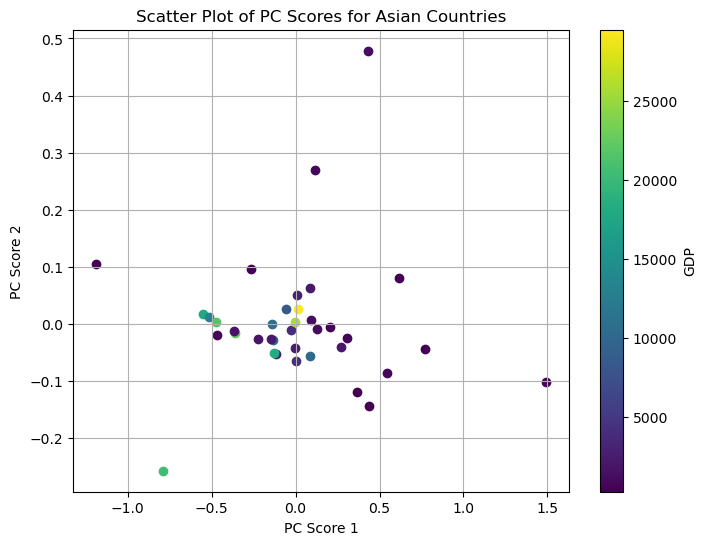

In [53]:
from adjustText import adjust_text
plt.figure(figsize=(8, 6))

# Use the recommended method to get the colormap
colormap = plt.colormaps['viridis']

# Normalize GDP values for color mapping
gdp_values = final_dataset.loc[final_dataset['Continent'] == 'Asia', 'Avg_GDP']
norm = plt.Normalize(gdp_values.min(), gdp_values.max())
europe_countries = final_dataset[final_dataset['Continent'] == 'Asia']['Entity'].unique()

texts = []
for i, country in enumerate(europe_countries):
    gdp_value = final_dataset.loc[final_dataset['Entity'] == country, 'Avg_GDP'].iloc[0]
    color = colormap(norm(gdp_value))  # Use normalized GDP value for color
    plt.scatter(unique_pc_score1[i], unique_pc_score2[i], color=color, label=country if i == 0 else "")
    #texts.append(plt.text(unique_pc_score1[i], unique_pc_score2[i], country))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.xlabel('PC Score 1')
plt.ylabel('PC Score 2')
plt.title('Scatter Plot of PC Scores for Asian Countries')
plt.grid(True)

# Explicitly specify the Axes for the colorbar
ax = plt.gca()  # Get the current Axes
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='GDP')  # Use the current Axes for the colorbar

plt.show()

Davies-Bouldin Score for Asian Countries: 1.8008828484367787
Silhouette Score for Asian Countries: 0.19845917923938103


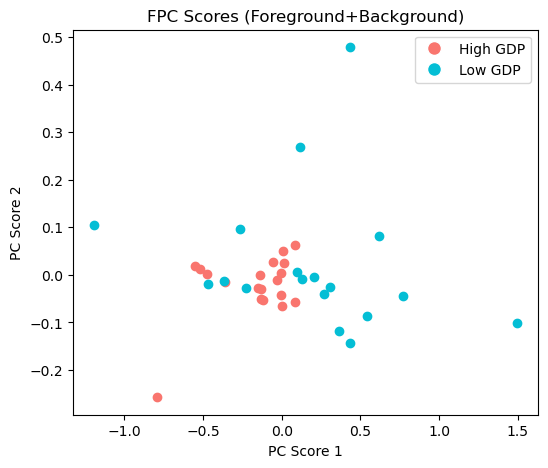

In [67]:
plt.figure(figsize=(6, 5))

# Calculate the median GDP per capita
median_gdp = final_dataset.loc[final_dataset['Continent'] == 'Asia', 'Avg_GDP'].median()

texts = []
for i, country in enumerate(europe_countries):
    gdp_value = final_dataset.loc[final_dataset['Entity'] == country, 'Avg_GDP'].iloc[0]
    
    # Determine color based on GDP being above or below the median
    color = '#F9756E' if gdp_value >= median_gdp else '#04BED5'  # Teal remains the same


    
    plt.scatter(unique_pc_score1[i], unique_pc_score2[i], color=color, label=f"{'High GDP' if color == 'blue' else 'Low GDP'}" if i == 0 else "")
    #texts.append(plt.text(unique_pc_score1[i], unique_pc_score2[i], country))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.xlabel('PC Score 1')
plt.ylabel('PC Score 2')
plt.title('FPC Scores (Foreground+Background)')
#plt.grid(True)

# Create a custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='#F9756E', markersize=10, label='High GDP'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='#04BED5', markersize=10, label='Low GDP')]
plt.legend(handles=legend_elements, loc='best')


# Step 1: Filter for European countries
asian_countries_df = final_dataset[final_dataset['Continent'] == 'Asia']

# Ensure unique rows per country if necessary
# Assuming the GDP per capita is consistent for each country, deduplicate if needed
unique_asian_countries_df = asian_countries_df.drop_duplicates(subset=['Entity'])

# Step 2: Determine the median GDP per capita among these European countries
median_gdp = unique_asian_countries_df['Avg_GDP'].median()

# Generate binary labels based on the median GDP per capita
labels_binary = unique_asian_countries_df['Avg_GDP'].apply(lambda x: 1 if x >= median_gdp else 0).to_numpy()

X = np.column_stack((unique_pc_score1, unique_pc_score2))

# Calculate the silhouette score
silhouette_avg = silhouette_score(X, labels_binary)

# Calculate the Davies-Bouldin Index using the same labels and PC scores
davies_bouldin_avg = davies_bouldin_score(X, labels_binary)

print(f"Davies-Bouldin Score for Asian Countries: {davies_bouldin_avg}")

print(f"Silhouette Score for Asian Countries: {silhouette_avg}")


Text(0, 0.5, 'DB Score')

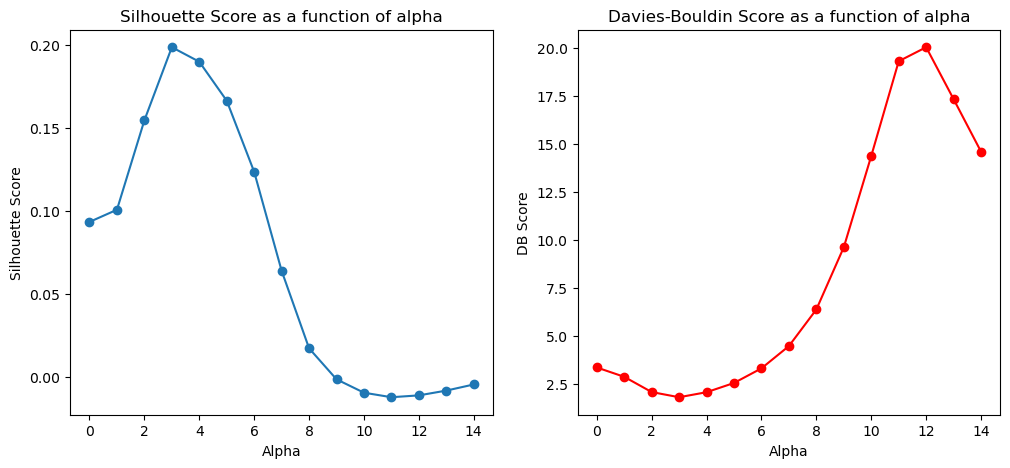

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.integrate
import skfda

def calculate_pc_scores_from_lists(data_lists, eigenvector, t):
    """
    Calculate the PC scores for each time series represented by a list in data_lists.
    
    Parameters:
    - data_lists: List of lists, each inner list is a time series for a company.
    - eigenvector: The eigenvector to use for calculating PC scores.
    - t: The time array over which to integrate.
    
    Returns:
    - A numpy array with PC scores for each time series.
    """
    # Convert data lists to a numpy array for efficient computation
    data_array = np.array(data_lists)
    
    # Calculate the integral using the trapezoidal rule for each time series
    pc_scores = np.array([simps(data_array[i] * np.real(eigenvector), dx = 1) for i in range(data_array.shape[0])])
    return pc_scores

# Function to compute FPCA components given foreground, background, and alpha
def compute_and_plot_components(foreground, background, alpha):
    components = CFPCA(standardized_asia_list, standardized_europe_list, alpha, t, True)

    unique_pc_score1 = calculate_pc_scores_from_lists(foreground, components[:,0], t)
    unique_pc_score2 = calculate_pc_scores_from_lists(foreground, components[:,1], t)
    X = np.column_stack((unique_pc_score1, unique_pc_score2))

    return X

alphas = range(0, 15)
silhouette_scores = []
db_scores = []

# Assuming silhouette and Davies-Bouldin score calculation requires clustering or similar, 
# we simulate this step for demonstration purposes

for alpha in alphas:
    X = compute_and_plot_components(standardized_asia_list,standardized_europe_list, alpha)
    silhouette_avg = silhouette_score(X, labels_binary)
    db_avg = davies_bouldin_score(X, labels_binary)
    
    silhouette_scores.append(silhouette_avg)
    db_scores.append(db_avg)

# Plotting the silhouette and DB scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(alphas, silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score as a function of alpha')
plt.xlabel('Alpha')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(alphas, db_scores, marker='o', linestyle='-', color='r')
plt.title('Davies-Bouldin Score as a function of alpha')
plt.xlabel('Alpha')
plt.ylabel('DB Score')


In [ ]:
# Categorizing the provided list of countries into developed, developing (third world), and neither categories
# This categorization will follow general conventions and recent classifications, noting that the distinctions can be nuanced.

developed_countries = [
    "Andorra", "Australia", "Austria", "Belgium", "Brunei", "Canada", "Cyprus", "Czechia", "Denmark",
    "Finland", "France", "Germany", "Greece", "Hong Kong", "Hungary", "Iceland", "Ireland", "Israel",
    "Italy", "Japan", "Kuwait", "Liechtenstein", "Luxembourg", "Malta", "Monaco", "Netherlands", "New Zealand",
    "Norway", "Poland", "Portugal", "Qatar", "San Marino", "Saudi Arabia", "Singapore", "Slovakia", "Slovenia",
    "South Korea", "Spain", "Sweden", "Switzerland", "Taiwan", "United Arab Emirates", "United Kingdom", "United States", "Macao"
]

developing_countries = [
    "Afghanistan", "Albania", "Algeria", "Angola", "Anguilla", "Antigua and Barbuda", "Argentina", "Armenia", "Aruba",
    "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belize", "Benin", "Bermuda", "Bhutan",
    "Bolivia", "Bonaire Sint Eustatius and Saba", "Bosnia and Herzegovina", "Botswana", "Brazil", "British Virgin Islands",
    "Bulgaria", "Burkina Faso", "Burundi", "Cambodia", "Cameroon", "Cape Verde", "Chad", "Chile", "China", "Colombia",
    "Comoros", "Congo", "Cook Islands", "Costa Rica", "Cote d'Ivoire", "Croatia", "Cuba", "Curacao", "Democratic Republic of Congo",
    "Djibouti", "Dominica", "Dominican Republic", "East Timor", "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea",
    "Estonia", "Eswatini", "Ethiopia", "Faroe Islands", "Fiji", "Gabon", "Gambia", "Georgia", "Ghana", "Greenland", "Grenada",
    "Guatemala", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "India", "Indonesia", "Iran", "Iraq", "Jamaica",
    "Jordan", "Kazakhstan", "Kenya", "Kiribati", "Kosovo", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia",
    "Libya", "Lithuania", "Macao", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Marshall Islands", "Mauritania",
    "Mauritius", "Mexico", "Micronesia (country)", "Moldova", "Mongolia", "Montenegro", "Montserrat", "Morocco", "Mozambique",
    "Myanmar", "Namibia", "Nauru", "Nepal", "Nicaragua", "Niger", "Nigeria", "Niue", "North Macedonia", "Oman", "Pakistan",
    "Palau", "Palestine", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Romania", "Russia", "Rwanda",
    "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa", "Sao Tome and Principe", "Senegal",
    "Serbia", "Seychelles", "Sierra Leone", "Sint Maarten (Dutch part)", "Solomon Islands", "Somalia", "South Sudan", "Sri Lanka",
    "Sudan", "Suriname", "Syria", "Tajikistan", "Tanzania", "Thailand", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia",
    "Turkey", "Turkmenistan", "Turks and Caicos Islands", "Tuvalu", "Uganda", "Ukraine", "Uruguay", "Uzbekistan", "Vanuatu",
    "Venezuela", "Vietnam", "Wallis and Futuna", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"]

neither_categories = [
    "Antarctica", "Christmas Island", "Faroe Islands", "Greenland", "Niue", "Saint Helena", "Saint Pierre and Miquelon", 
    "Wallis and Futuna", "Sint Maarten (Dutch part)", "Turks and Caicos Islands", "British Virgin Islands", "Bermuda", "Anguilla",
    "Montserrat", "Bonaire Sint Eustatius and Saba"
]


def categorize_country(entity):
    if entity in developed_countries:
        return 'Developed'
    elif entity in developing_countries:
        return 'Developing'
    else:
        return 'Neither'

final_dataset['Category'] = final_dataset['Entity'].apply(categorize_country)


developing_countries_series = []
developed_countries_series = []

# Group the DataFrame by 'Category' and 'Entity'
grouped = final_dataset.groupby(['Category', 'Entity'])

# Iterate over each group
for (category, entity), group in grouped:
    if category == 'Developing':
        developing_countries_series.append(group['Co2'].tolist())
    elif category == 'Developed':
        developed_countries_series.append(group['Co2'].tolist())


developing_countries_series = [series for series in developing_countries_series if len(series) == 23]



In [ ]:
def standardize_time_series(data_list, log_transform=False, individual=False, across_time_points=False):
    """
    Standardize time series data based on selected options.

    Parameters:
    - data_list: List of lists, where each inner list represents a time series.
    - log_transform: Boolean, if True, apply log transformation to the data before standardizing.
    - individual: Boolean, if True, standardize each time series individually.
    - across_time_points: Boolean, if True, standardize across all time points.

    Returns:
    - List of standardized time series data.
    """

    # Apply log transformation if requested
    if log_transform:
        data_list = [np.log1p(series) for series in data_list]

    if individual:
        # Standardize each series individually
        standardized_data = [(series - np.mean(series)) / np.std(series) for series in data_list]
    
    elif across_time_points:
        # Convert to NumPy array for easier manipulation
        data_array = np.array(data_list)
        # Standardize across all time points
        means = np.mean(data_array, axis=0)
        stds = np.std(data_array, axis=0)
        standardized_data = (data_array - means) / stds
        standardized_data = standardized_data.tolist()
    
    else:
        # Default behavior if neither individual nor across_time_points is specified
        raise ValueError("Either 'individual' or 'across_time_points' must be True.")

    return standardized_data



def compute_and_plot_components(foreground, background, alpha):
    # Define time points
    t = np.linspace(0, 22, 23)
    fd_X = skfda.FDataGrid(foreground, t)
    fd_Y = skfda.FDataGrid(background, t)
    basis = skfda.representation.basis.BSplineBasis(n_basis=9)
    X_basis = fd_X.to_basis(basis)
    Y_basis = fd_Y.to_basis(basis)

    X_fd_data = fd_X.data_matrix.reshape(fd_X.data_matrix.shape[:-1])
    Y_fd_data = fd_Y.data_matrix.reshape(fd_Y.data_matrix.shape[:-1])

    X_identity = np.eye(len(fd_X.grid_points[0]))
    Y_identity = np.eye(len(fd_Y.grid_points[0]))

    X_weights = scipy.integrate.simpson(X_identity, fd_X.grid_points[0])
    Y_weights = scipy.integrate.simpson(Y_identity, fd_Y.grid_points[0])

    X_weights_matrix = np.diag(X_weights)
    Y_weights_matrix = np.diag(Y_weights)

    X_factorization_matrix = X_weights_matrix.astype(float)
    Y_factorization_matrix = Y_weights_matrix.astype(float)

    X_Lt = np.linalg.cholesky(X_factorization_matrix).T
    Y_Lt = np.linalg.cholesky(Y_factorization_matrix).T

    new_data_matrix_X = X_fd_data @ X_weights_matrix
    new_data_matrix_X = np.linalg.solve(X_Lt.T, new_data_matrix_X.T).T

    new_data_matrix_Y = Y_fd_data @ Y_weights_matrix
    new_data_matrix_Y = np.linalg.solve(Y_Lt.T, new_data_matrix_Y.T).T

    # Center the matrix X by subtracting the mean of each column
    X_centered = new_data_matrix_X #- np.mean(new_data_matrix_X, axis=0)
    Y_centered = new_data_matrix_Y #- np.mean(new_data_matrix_Y, axis=0)

    Vx = (1 / (len(foreground) - 1)) * np.dot(X_centered.T, X_centered)
    Vy = (1 / (len(background) - 1)) * np.dot(Y_centered.T, Y_centered)

    # Perform the eigen decomposition on the covariance matrix V
    eigenvalues, eigenvectors = np.linalg.eig(Vx - alpha * Vy)

    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    components = np.linalg.solve(X_Lt, sorted_eigenvectors[:, :4]).T

    # Plot the first three components
    plt.figure(figsize=(8, 4))
    for i in range(3):
        plt.plot(components[i], label=f'Component {i+1}')
    #plt.legend()
    plt.title('First Three Components')
    plt.show()

    return components

standardized_developing_list = standardize_time_series(developing_countries_series, log_transform=True, individual=False, across_time_points = True)
standardized_developed_list = standardize_time_series(developed_countries_series, log_transform=True, individual=False, across_time_points=True)

# Example usage:
#shared_components = compute_and_plot_components(standardized_europe_list,standardized_asia_list , 0)
unique_components = compute_and_plot_components(standardized_developed_list,standardized_developing_list,4)

#NON PERIODIC CASE

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps


def calculate_pc_scores_from_lists(data_lists, eigenvector):
    """
    Calculate the PC scores for each time series represented by a list in data_lists.
    
    Parameters:
    - data_lists: List of lists, each inner list is a time series for a company.
    - eigenvector: The eigenvector to use for calculating PC scores.
    - t: The time array over which to integrate.
    
    Returns:
    - A numpy array with PC scores for each time series.
    """
    # Convert data lists to a numpy array for efficient computation
    data_array = np.array(data_lists)
    
    # Calculate the integral using the trapezoidal rule for each time series
    pc_scores = np.array([simps(data_array[i] * np.real(eigenvector), dx = 1) for i in range(data_array.shape[0])])
    return pc_scores


unique_pc_score1 = calculate_pc_scores_from_lists(standardized_developed_list, unique_components[0])
unique_pc_score2 = calculate_pc_scores_from_lists(standardized_developed_list, unique_components[1])


import matplotlib.pyplot as plt
from adjustText import adjust_text

developing_countries = filtered_co2[filtered_co2['Category'] == 'Developed']['Entity'].unique()

# Assuming `unique_pc_score1` and `unique_pc_score2` are your calculated PC scores.
# And `developing_countries` contains the list of country names in the same order as the PC scores.
plt.figure(figsize=(8, 6))

texts = []
for i, country in enumerate(developing_countries):
    plt.scatter(unique_pc_score1[i], unique_pc_score2[i])
    # Add each country's text label to the plot
    texts.append(plt.text(unique_pc_score1[i], unique_pc_score2[i], country))

# Use adjust_text with arrowprops without 'autoalign'
adjust_text(texts, 
            arrowprops=dict(arrowstyle='->', color='red'))

plt.xlabel('PC Score 1')
plt.ylabel('PC Score 2')
plt.title('Scatter Plot of PC Scores for Developing Countries')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
import numpy as np

# Assuming you have a DataFrame `final_dataset` with the necessary data
# and `unique_pc_score1` and `unique_pc_score2` represent your Principal Component scores for the countries.

# Filter 'final_dataset' to include only developing countries and their average GDP
developing_countries_df = final_dataset[final_dataset['Entity'].isin(developing_countries)]

# Since PC scores are not provided, let's assume you have them in the same order as 'developing_countries_df'
# For demonstration, replace 'unique_pc_score1' and 'unique_pc_score2' with actual values or calculation methods

# Create a colormap based on the average GDP
norm = plt.Normalize(developing_countries_df['Avg_GDP'].min(), 
                     developing_countries_df['Avg_GDP'].max())
cmap = plt.cm.viridis

plt.figure(figsize=(8, 6))

texts = []
for i, row in developing_countries_df.iterrows():
    country = row['Entity']
    # Find the index of the country in the `developing_countries` list to match PC scores
    index = np.where(developing_countries == country)[0][0]
    color = cmap(norm(row['Avg_GDP']))
    plt.scatter(unique_pc_score1[index], unique_pc_score2[index], color=color)
    #texts.append(plt.text(unique_pc_score1[index], unique_pc_score2[index], country, color=color))

# Use adjust_text with arrowprops without 'autoalign'
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# Adding a colorbar to represent the average GDP values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Average GDP 2000-2022')

plt.xlabel('PC Score 1')
plt.ylabel('PC Score 2')
plt.title('Scatter Plot of PC Scores for Developing Countries by Average GDP')
plt.grid(True)
plt.show()
